In [32]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shdom



In [33]:
def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

def projection_split(projections, n_parts):
    avg = len(projections.projection_list) / float(n_parts)
    out = []
    last = 0.0

    while last < len(projections.projection_list):
        out.append(shdom.MultiViewProjection(projections.projection_list[int(last):int(last + avg)]))
        last += avg

    return out

In [34]:
"""
Set settings
"""
#355, 380, 445, 470, 555, 660, 865, 935
wavelengths = [0.660]
vel_cloud = np.array([0.0,0.0,0.0]) # m/s
vel_camera = 220 # m/s
# A fly over from West to East (positive y-axis direction)
camera_zenith_list = [65, 62, 58, 54, 50, 44, 38, 30, 21, 11, 0, 11, 21, 30, 38, 44, 50, 54, 58,62, 65]
camera_azimuth_list = [-90, -90, -90, -90, -90, -90, -90, -90, -90, -90, 0, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
num_of_viewed_medium = len(camera_zenith_list)

projection_type = 'perspective'
# projection_type = 'orthographic'

# input_cloud = 'rico52x57x26'
# input_cloud = 'rico32x37x26'
input_cloud = 'BOMEX2'

if len(wavelengths) > 1:
    type = 'polychromatic'
else:
    type = 'monochromatic'


output_dir = 'cvpr/{}_dt_airmspi_single_platform_wl_{}_images_{}_projection_{}/dynamic_medium_{}'.format(input_cloud, np.array_str(np.array(wavelengths)).replace(" ", ","),
                                                                                   num_of_viewed_medium, projection_type,type)

# sun
sun_azimuth_list=np.linspace(25,25+0.1*num_of_viewed_medium,num_of_viewed_medium)
sun_zenith_list=np.linspace(121.07,121.07-0.035*(num_of_viewed_medium-1),num_of_viewed_medium)

# solver
iter = 100


# Set data directory
# data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W'
data_dir = '../AirMSPI/21views'

format_ = '*.hdf'  # load
paths = sorted(glob.glob(data_dir + '/' + format_))
# roi = [[1088, 1408, 600, 1000], [1156, 1480, 640, 1000], [1216, 1556, 696, 1100], [1280, 1620, 732, 1100], [1340, 1684, 792, 1200], [1404, 1744, 828, 1200], [1460, 1812, 950, 1300], [1528, 1884, 1000, 1400], [1492, 1852, 1100, 1650]]
import scipy.io as sio
# roi=(shdom.AirMSPIMeasurements().select_region_of_interest(data_dir,0))
roi = [[1164, 1460, 1400, 1800]]*21
wavelengths = [660]#355, 380, 445, 470, 555, 660, 865, 935
airmspi_measurements = shdom.AirMSPIDynamicMeasurements()
airmspi_measurements.load_from_hdf(data_dir,region_of_interest=roi,valid_wavelength=wavelengths)
projections = airmspi_measurements._projections
wavelengths = [0.660]
# sun
sun_azimuth_list=airmspi_measurements.sun_azimuth_list
sun_zenith_list=airmspi_measurements.sun_zenith_list
time_list = airmspi_measurements.time_list

Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215430Z_CA-Nicasio_646F_F01_V005.hdf has invalid region of interest
Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215455Z_CA-Nicasio_615F_F01_V005.hdf has invalid region of interest
Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215518Z_CA-Nicasio_580F_F01_V005.hdf has invalid region of interest
Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215539Z_CA-Nicasio_541F_F01_V005.hdf has invalid region of interest
Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215712Z_CA-Nicasio_212F_F01_V005.hdf has invalid region of interest
Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215730Z_CA-Nicasio_110F_F01_V005.hdf has invalid region of interest
Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSOID_20130203_215748Z_CA-Nicasio_000N_F01_V005.hdf has invalid region of interest
Data at path=../AirMSPI/21views/AirMSPI_ER2_GRP_ELLIPSO

In [35]:
for pro in projections.projection_list:
    pro._x += 1.5
    pro._y += 0
dynamic_projection = shdom.DynamicProjection(projection_split(projections, num_of_viewed_medium))

In [36]:
# Mie scattering for water droplets
mie_table_paths = [
    '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
    for wavelength in wavelengths
]

solar_spectrum = shdom.SolarSpectrum('../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths)

In [37]:
# Load a Microphysical scatterer
droplets = shdom.MicrophysicalScatterer()
if input_cloud == 'BOMEX2':
    camera_height = 20 #km
    assert np.any(vel_cloud==np.array([0.0,0.0,0.0]))
    data_dir = '../synthetic_cloud_fields/WIZ_Clouds/BOMEX2'
    format_ = '*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    droplets.load_from_csv(volumes_paths[100])
    grid = shdom.Grid(x=droplets.grid.x[357:400],y=droplets.grid.y[340:370],z=np.linspace(0,1.5,45))
    droplets.resample(grid)


In [38]:
# com_x, com_y, com_z = calccenterofmass(droplets=droplets)
# com = np.array([com_x, com_y, com_z])
# 
# L_list = (np.sign(camera_azimuth_list)) * (camera_height - com_z) * np.tan(np.deg2rad(camera_zenith_list) )
# 
# # time_list = np.array(L_list *1e3 / vel_camera)
time_list -= time_list.min()
time_list = np.round(time_list/5)*5
# time_list = np.linspace(0,20*10,21)
# 
# #sec
# camera_position_list = np.zeros([L_list.shape[0],3])

# move the camera instead of the cloud
# camera_position_list[:, 0] = com_x
# camera_position_list[:, 1] = com_y + np.asarray(L_list)
# camera_position_list[:, 2] = camera_height

In [39]:
# Load a Microphysical scatterer
droplets = shdom.MicrophysicalScatterer()
indeces = time_list/5
if input_cloud=='BOMEX2':
    camera_height = 20 #km
    data_dir = '../synthetic_cloud_fields/WIZ_Clouds/BOMEX2'
    format_ = '*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    # volumes_paths = [volumes_paths[int(100+i)] for i in indeces]
    volumes_paths = [volumes_paths[int(65+i)] for i in indeces]
    # volumes_paths = volumes_paths[-1-num_of_viewed_medium:-1]
    # volumes_paths = [volumes_paths[-1]]*num_of_viewed_medium
    droplets.load_from_csv(volumes_paths[0])


In [40]:
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))


In [41]:
air = shdom.MultispectralScatterer()
mie_list = []
for wavelength, table_path in zip(wavelengths, mie_table_paths):  
        # Molecular Rayleigh scattering
        rayleigh = shdom.Rayleigh(wavelength)
        rayleigh.set_profile(temperature_profile.resample(air_grid))
        air.add_scatterer(rayleigh.get_scatterer())
        mie = shdom.MiePolydisperse()
        mie.read_table(table_path)
        mie_list.append(mie)

Reading mie table from file: ../mie_tables/polydisperse/Water_660nm.scat


In [42]:
temporary_scatterer_list = []
time_list = []
for volumes_path in volumes_paths:
    s = volumes_path
    time = int(s[s.rfind('_')+1:s.rfind('.txt')])/2
    time_list.append(time)
    droplets = shdom.MicrophysicalScatterer()
    droplets.load_from_csv(volumes_path)
    for mie in mie_list:  
        droplets.add_mie(mie)
    droplets.resample(grid)

    # pad with zeros
    for data in [droplets.lwc.data, droplets.reff.data, droplets.veff.data]:
        data[0,:,:] = 0
        data[:,0,:] = 0
        data[:,:,0] = 0
        data[-1,:,:] = 0
        data[:,-1,:] = 0
        data[:,:,-1] = 0
        
    temporary_scatterer_list.append(shdom.TemporaryScatterer(droplets,time)) 
# time_list = np.mean(np.split(np.array(time_list),num_of_viewed_medium),1)       


Minimum medium effective radius [0.15] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.02]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.12] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.02]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.11] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting ex

In [43]:
dynamic_scatterer = shdom.DynamicScatterer()
dynamic_scatterer.add_temporary_scatterer(temporary_scatterer_list)

dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air)

In [44]:
scene_params_list = []
numerical_params_list =[]
for sun_azimuth, sun_zenith in zip(sun_azimuth_list, sun_zenith_list):
    scene_params=[]
    numerical_params=[]
    for wavelength, solar_flux in zip(wavelengths, solar_fluxes):
        scene_params.append( shdom.SceneParameters(
            wavelength=wavelength,
            source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith, flux=solar_flux)
        ))
        numerical_params.append(shdom.NumericalParameters(num_mu_bins=8,num_phi_bins=16))
    scene_params_list.append(scene_params)
    numerical_params_list.append(numerical_params)

In [45]:
dynamic_solver = shdom.DynamicRteSolver(scene_params=scene_params_list,numerical_params=numerical_params_list)
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter,verbose=True)

In [46]:
# projections = shdom.MultiViewProjection()
# 
# for camera_azimuth,camera_zenith,camera_position in zip(camera_azimuth_list,camera_zenith_list,camera_position_list):
#      
#     if projection_type == 'perspective':
#          projection = (
#                 shdom.PerspectiveProjection(fov=2, 
#                 nx=200, ny=200, x=camera_position[0], y=camera_position[1],
#                 z=camera_position[2])
#             )  
#          projection.look_at_transform(point=com, up=[0.0, 0.0, 1.0])
#          projections.add_projection(projection)
#     elif projection_type == 'pushbroom':
#         projection = (
#                 # shdom.PushBroomProjection(fov=30,x_resolution=0.01,y_resolution=0.01,
#                 #                           x=camera_position[0], y=camera_position[1], z=camera_position[2],
#                 #                           zenith=camera_zenith)
#                 shdom.PushBroomProjection(fov=30, nx=200, ny=200, x=camera_position[0], 
#                                           y=camera_position[1],
#                 z=camera_position[2],bounding_box=droplets.bounding_box)
#             )  
#         projection.look_at_transform(point=com, up=[0.0, 0.0, 1.0])
#         projections.add_projection(projection)
#     else:
#         projections.add_projection(
#             shdom.OrthographicProjection(droplets.bounding_box,x_resolution=0.01,
#                                          y_resolution=0.01,azimuth=camera_zenith,zenith=camera_zenith))
# 
# dynamic_projection = shdom.DynamicProjection(projection_split(projections, num_of_viewed_medium))


In [47]:
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), dynamic_projection)
images = dynamic_camera.render(dynamic_solver,n_jobs=72)

In [48]:
images_cropped =[]
new_projs = []
for im, proj in zip(images, projections.projection_list):
    indeces = np.unravel_index(np.argmax(np.array(im), axis=None), np.array(im).shape)
    [m,n]=np.shape(im)
    min_x = np.max([indeces[0]-50,0])
    min_y = np.max([indeces[1]-50,0])
    max_x = np.min([indeces[0]+55,m])
    max_y = np.min([indeces[1]+55,n])
    im_cropped = im[min_x:max_x,min_y:max_y]
    images_cropped.append(im_cropped)
    mask = np.zeros(im.shape, dtype=np.bool)
    mask[min_x:max_x,min_y:max_y]=True
    new_proj = proj[mask.ravel(order='F')]
    new_proj._resolution = im_cropped.shape
    new_projs.append(new_proj)
        
new_projs=shdom.MultiViewProjection(new_projs)
dynamic_projection = shdom.DynamicProjection(projection_split(new_projs, num_of_viewed_medium))
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), dynamic_projection)

In [49]:
measurements = shdom.DynamicMeasurements(camera=dynamic_camera, images=images_cropped, wavelength=wavelengths,time_list=time_list)
measurements.set_noise(shdom.AirMSPINoise())

In [50]:
shdom.save_dynamic_forward_model(output_dir, dynamic_medium, dynamic_solver, measurements)

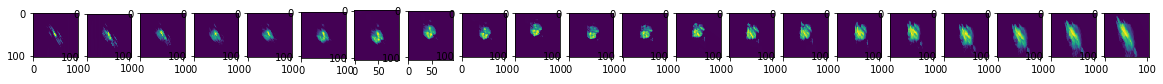

In [51]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr, images_cropped):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1)),image),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    ax.imshow(image/image.max())


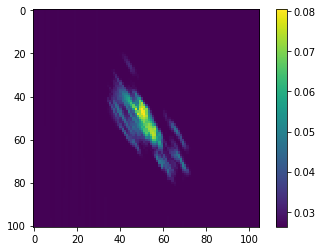

In [52]:
plt.imshow(images_cropped[1])
plt.colorbar()
# # %matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init()
# x_min = projections.x.min()
# x_max = projections.x.max()
# y_min = projections.y.min()
# y_max = projections.y.max()
# projections.projection_list[3].plot(ax,[1, 3],[y_min, 0],[0, 20],20)

In [ ]:
a,b,c = shdom.load_dynamic_forward_model(output_dir)
print()
  

In [ ]:
# camera_zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
# np.cos(np.deg2rad(camera_zenith_list))**2